In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

#%matplotlib inline

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
import sys
from utils.commandline import load_config
from importlib.machinery import SourceFileLoader
from datasets.web_caricature import WebCaricatureDataset

In [4]:
# load configuration file from specified configuration file path
config = SourceFileLoader('config', './config/config_train.py').load_module()

6128 images of 126 classes loaded.
Classes 126: 3016 photos, 3112 caricatures

Device: cpu



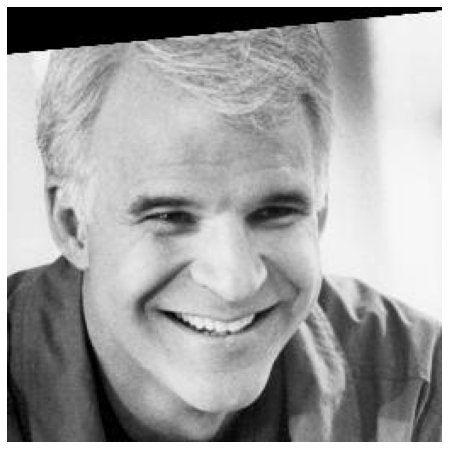

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = WebCaricatureDataset(config)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.in_batch, shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(f"\nDevice: {device}\n")

# Plot some training images
batch = next(iter(dataloader))

photo = batch["images_photo"]
caric = batch["images_caric"]

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(photo[0], (1, 2, 0)))

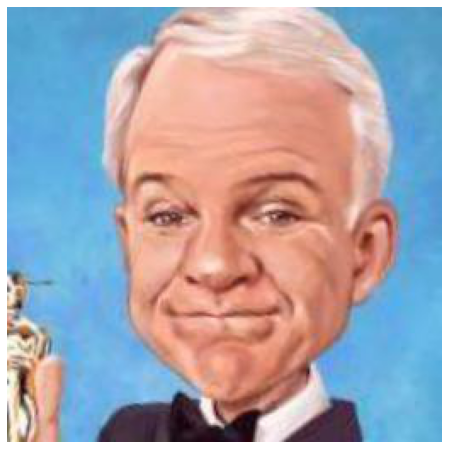

In [6]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(caric[0], (1, 2, 0)))

In [7]:
from losses.model_losses  import AdversarialLoss, PatchAdversarialLoss
from models.model_warpgan import WarpGANGenerator, WarpGANDiscriminator

In [8]:
# load model

# Create the generator
warpgan_generator     = WarpGANGenerator(config).to(device)
warpgan_discriminator = WarpGANGenerator(config).to(device)


In [9]:
# load losses

adversarial_loss = AdversarialLoss()
patch_adversarial_loss = PatchAdversarialLoss() 


In [10]:
# Setup Adam optimizers for both G and D

optimizerG = optim.Adam(warpgan_generator.parameters(), lr=config.lr, 
                        betas=(config.optimizer[1]["beta1"], config.optimizer[1]["beta2"]))

optimizerD = optim.Adam(warpgan_discriminator.parameters(), lr=config.lr,
                        betas=(config.optimizer[1]["beta1"], config.optimizer[1]["beta2"]))


In [ ]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Learning to Caricaturize...")

# For each epoch
for epoch in range(config.num_epochs):
    
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
                
        input_dict = {
            
            "images_photo" : data["images_photo"],
            "images_caric" : data["images_caric"],
            
            "labels_photo" : data["labels_photo"],
            "labels_caric" : data["labels_caric"],
            
            "scales_photo" : data["scales_photo"],
            "scales_caric" : data["scales_caric"],
            
        }
        
        ############################
        # (1) Update Discriminator network:
        ###########################
        ## Train with all-real batch
        warpgan_discriminator.zero_grad()
        
        # Forward pass real batch through D
        output = warpgan_discriminator(input_dict).view(-1)
        
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
        
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
        
#         D_x = output.mean().item()

#         ## Train with all-fake batch

#         # Generate fake image batch with G
#         fake = netG(noise)
#         label.fill_(fake_label)
        
#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
        
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
        
#         # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
        
#         # Compute error of D as sum over the fake and the real batches
#         errD = errD_real + errD_fake
        
#         # Update D
#         optimizerD.step()

#         ############################
#         # (2) Update Generator network:
#         ###########################
        
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
        
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake).view(-1)
        
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
        
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
        
#         # Update G
#         optimizerG.step()

#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

#         # Save Losses for plotting later
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())

#         # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
                
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1



Learning to Caricaturize...
> /Users/firattamur/Desktop/fall21/courses/comp411/WarpGAN-PyTorch/models/m2modules_warpgan/modules_decoder/controller_decoder.py(200)forward()
    198         # inp: (in_batch, initial*4, in_height,   in_width)
    199         # out: (in_batch, initial,   in_height*4, in_width*4)
--> 200         out  = self.deconvs(out[0])
    201 
    202         # inp: (in_batch, initial,   in_height*4, in_width*4)

ipdb> n
> /Users/firattamur/Desktop/fall21/courses/comp411/WarpGAN-PyTorch/models/m2modules_warpgan/modules_decoder/controller_decoder.py(204)forward()
    202         # inp: (in_batch, initial,   in_height*4, in_width*4)
    203         # out: (in_batch, 3,         in_height*4, in_width*4)
--> 204         out = self.conv(out)
    205 
    206         # inp: (in_batch, 3,         in_height*4, in_width*4)

ipdb> out.shape
torch.Size([2, 64, 256, 256])
ipdb> n
RuntimeError: Given groups=1, weight of size [3, 256, 7, 7], expected input[2, 64, 256, 256] to have 25